# Machine Learning Project \#2
## Name: Nick Pittman
## Due Date: 12/10/21

## <u>Problem</u>
Using Scikit Learn software to build Support Vector Classification, Perceptron, Multilayer Perceptron, and Principal Component Analysis models, this experiment will attempt to predict the sentiment of a movie review based on the review's word choice. In total, this data set contains 50,000 anonymous movie reviews with their corresponding rating, and will be split into subsets for training and testing purposes. If successful, the highest performing machine learning model could be applied to several other applications outside of the movie industry, such as food reviews for a restaurant or product reviews for a company.

## <u>Attempted Points</u>
20/20


## Input Pipeline (sklearn and GPU):

In [1]:
from google.colab import drive
import pandas
drive.mount('/content/drive')
data = pandas.read_csv('/content/drive/MyDrive/Datasets/IMDB_Dataset.csv')
data.head()

MessageError: ignored

In [ ]:
#install GPU to speed up runtime
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Data Exploration:
- Number of samples
- Number of classes of the target variable
- Number of words per sample
- Distribution of sample length
- Comparison of the dataset's observed and theoretical mean for sentiment

In [ ]:
## Use cells here to explore the data:
## number of samples
data.shape # 50,000 reviews with 2 features (review and sentiment)

(50000, 2)

In [ ]:
## number of classes of the target variable
print(data['sentiment'].unique())
print('Number of potential sentiments : ', len(data['sentiment'].unique())) #only positive and negative class outputs

['positive' 'negative']
Number of potential sentiments :  2


In [ ]:
import statistics

# median number of words per sample
review_word_count = []
for i in range(len(data)):
  review = data['review'].iloc[i]
  review_split = review.split()
  word_count = len(review_split)
  review_word_count.append(word_count)

print('Median word count for one review: ', statistics.median(review_word_count))

Median word count for one review:  173.0


Text(0.5, 1.0, 'Distribution of Movie Review Word Count')

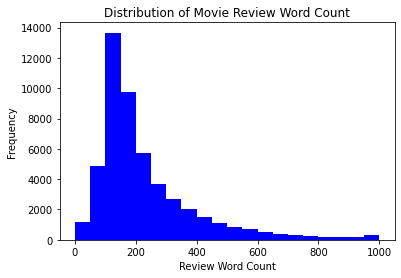

In [ ]:
import matplotlib.pyplot as plt

# distribution of number of words per review
plt.hist(x=review_word_count, bins=20, color='blue', range=(0,1000))
plt.xlabel('Review Word Count')
plt.ylabel('Frequency')
plt.title('Distribution of Movie Review Word Count')

In [ ]:
# finding expected value for Sentiment
# let a postiive sentiment = 1, negative sentiment = 0
sentiment_scores = []
for score in data['sentiment']:
  if score == "positive":
      score = 1
  else:
      score = 0
  sentiment_scores.append(score)

#Assume the chance of a positive or negative review is equally likely
print('Expected Sentiment: ', 1*1/2 + 0*1/2)
print('True Mean Sentiment: ', statistics.mean(sentiment_scores))
#Expected Sentiment equals the true average sentiment score
#This is good for the machine learning models -- will not be biased in either direction

Expected Sentiment:  0.5
True Mean Sentiment:  0.5


## Data Preparation

_To prepare the data for analysis, there were a few steps that needed to be completed. First, I needed to import a package that would remove stopwords from each review and make each letter lowercase. This will make the data much easier to work with since all the words that remain will be valuable to the machine learning models and be presented in the same case. This was the purpose of removing the stopwords, as they do not provide much useful information (such as a, the, is, are, etc.) and would only add clutter to the training of my models. I then ran a loop on the data set to clean all the text with these new parameters and created seperate training and testing data sets._

### Cleaning the data

In [ ]:
from bs4 import BeautifulSoup
import re
import nltk
#only do next line once
nltk.download() #in Corpora tab, download stopwords
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
#The NLTK downloader will open, you need to select (d) for Download, and then 'stopwords', and then (q) to quit

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> stopwords
      Unzipping corpora/stopwords.zip.

---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


In [ ]:
#This is a function that takes in a review, makes sure it is only lower case letters and removes stopwords.
#It returns the cleaned review text.
def clean_review(review):
    #input is a string review
    #return is review cleaned of all punctuation, lowercase, and removed nltk stopwords
    letters_only = re.sub("[^a-zA-Z]"," ",review)
    lower_case = letters_only.lower()
    words = lower_case.split()
    for stop_word in stopwords.words("english"):
        while stop_word in words:
            words.remove(stop_word)
    cleaned = " ".join(words)
    return cleaned

In [ ]:
#process the data
cleaned_text = []
for i in range(len(data)):
    cleaned_text.append(clean_review(data["review"][i]))

In [ ]:
cleaned_text[:5]

['one reviewers mentioned watching oz episode hooked right exactly happened br br first thing struck oz brutality unflinching scenes violence set right word go trust show faint hearted timid show pulls punches regards drugs sex violence hardcore classic use word br br called oz nickname given oswald maximum security state penitentary focuses mainly emerald city experimental section prison cells glass fronts face inwards privacy high agenda em city home many aryans muslims gangstas latinos christians italians irish scuffles death stares dodgy dealings shady agreements never far away br br would say main appeal show due fact goes shows dare forget pretty pictures painted mainstream audiences forget charm forget romance oz mess around first episode ever saw struck nasty surreal say ready watched developed taste oz got accustomed high levels graphic violence violence injustice crooked guards sold nickel inmates kill order get away well mannered middle class inmates turned prison bitches du

In [ ]:
#establish training and testing dataset
train_data, test_data, train_sln, test_sln = \
    train_test_split(cleaned_text, data['sentiment'], test_size = 0.2, random_state=21)

### Vectorizing the data

**CountVectorizer**: Convert a collection of text documents to a matrix of token counts

_In this section I vectorized the data to convert each word to a number based on predetermined tokens. Since it would be highly inefficient to create dummy variables for every word in the data set, I limited the number of possible words for vectorization to 1000. These words represent the 1000 most popular words in the English language. I then fit my training and testing data into these vectors so they could be used for analysis._

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

#Bag of Words with the 1000 most common words
vectorizer = CountVectorizer(analyzer='word', max_features = 1000)
#find the right 1000 words
vectorizer.fit(train_data)

#use the vectorizer to transform review strings into word count vectors
train_data_vectors = vectorizer.transform(train_data).toarray()
test_data_vectors = vectorizer.transform(test_data).toarray()

train_data_vectors

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

## Metrics

_The metrics I will be using to test my model will be percent accuracy and confusion matrices. Since my target variable is categorical, calculating the frequency at which my model correctly predicts the sentiment of the movie review is the most logical. I can then use confusion matrices to analyze these predictions closer and specifically identify where my model is making mistakes._

###Support Vector Classifier

__Paramters tuned:__ degree of kernel algorithm <br>
__Other adjustments:__ kernel type to polynomial, max iterations limited to 100, fixed random state, gamma increased to 2 for more precision

In [ ]:
## Now use train_data_vectors and test_data_vectors to train/test/tune your sklearn models.
# import packages for calculations, graphs, and SVC model
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn import metrics

degree = [1,2,3,4,5,6]
svc_accuracies = []
svc_max_accuracy = 0
svc_best_degree = 0
svc_best_predictions = []
current_svc_accuracy = 0

#load up scikit-learn SVC (Support Vector Classifier)
for d in degree:
  svc = SVC(kernel='poly', degree=d, max_iter=100, random_state=21, gamma=2)
  svc.fit(train_data_vectors,train_sln)
  predictions_svc = svc.predict(test_data_vectors)
  current_svc_accuracy = metrics.accuracy_score(test_sln, predictions_svc)
  if current_svc_accuracy > svc_max_accuracy:
    svc_best_degree = d
    svc_max_accuracy = current_svc_accuracy
    svc_best_predictions = predictions_svc
  svc_accuracies.append(current_svc_accuracy)

#Conclusion
print("Best Degree: ", svc_best_degree)
print("Best SVC accuracy: ", svc_max_accuracy)

Best Degree:  1
Best SVC accuracy:  0.5347


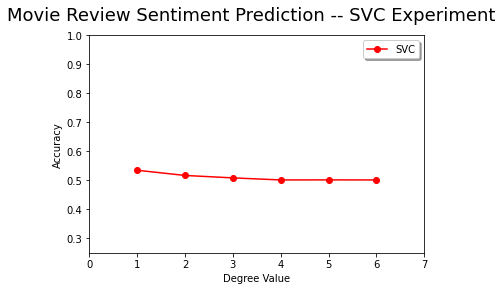

--------------------------------------------------------------
            P positive  P negative
T positive        4247         767
T negative        3886        1100


In [ ]:
#SVC graph
plt.suptitle('Movie Review Sentiment Prediction -- SVC Experiment',fontsize=18)
plt.xlabel('Degree Value')
plt.ylabel('Accuracy')
plt.plot(degree,svc_accuracies,'ro-',label='SVC')
plt.legend(loc='best', shadow=True)
plt.axis([0,7,.25,1.0])
plt.show()

print("--------------------------------------------------------------")

#SVC confusion matrix
vals = data['sentiment'].unique() ## possible classification values
conf_mat_svc = metrics.confusion_matrix(test_sln, svc_best_predictions, labels=vals)
print(pd.DataFrame(conf_mat_svc, index = "T " + vals, columns = "P " + vals))

### Perceptron

__Parameters tuned:__ learning rate (eta) <br>
__Other adjustments:__ max iterations limited to 100, fixed random state, use l2 regularization term for penalty

In [ ]:
# import package for Perceptron model
from sklearn.linear_model import Perceptron

eta = [0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00]
perc_accuracies = []
perc_max_accuracy = 0
perc_best_eta = 0
perc_best_predictions = []
current_perc_accuracy = 0

#load in scikit-learn Perceptron
for e in eta:
  perc = Perceptron(eta0=e, max_iter=100, random_state=21, penalty='l2')
  perc.fit(train_data_vectors, train_sln)
  predictions_perc = perc.predict(test_data_vectors)
  current_perc_accuracy = metrics.accuracy_score(test_sln, predictions_perc)
  if current_perc_accuracy > perc_max_accuracy:
    perc_best_eta = e
    perc_max_accuracy = current_perc_accuracy
    perc_best_predictions = predictions_perc
  perc_accuracies.append(current_perc_accuracy)

#Conclusion
print("Best Eta: ", perc_best_eta)
print("Best Perceptron accuracy: ", perc_max_accuracy)

Best Eta:  0.5
Best Perceptron accuracy:  0.8226


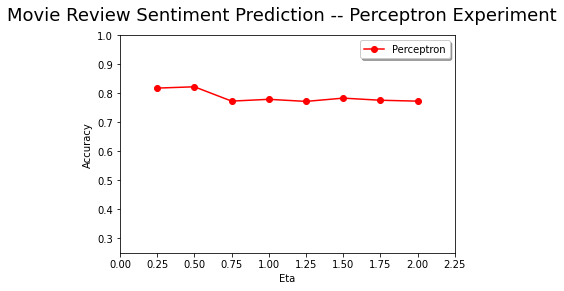

--------------------------------------------------------------
            P positive  P negative
T positive        4148         866
T negative         908        4078


In [ ]:
#Perceptron graph
plt.suptitle('Movie Review Sentiment Prediction -- Perceptron Experiment',fontsize=18)
plt.xlabel('Eta')
plt.ylabel('Accuracy')
plt.plot(eta, perc_accuracies, 'ro-', label='Perceptron')
plt.legend(loc='best', shadow=True)
plt.axis([0,2.25,.25,1.0])
plt.show()

print("--------------------------------------------------------------")

#Perceptron confusion matrix
conf_mat_perc = metrics.confusion_matrix(test_sln, perc_best_predictions, labels=vals)
print(pd.DataFrame(conf_mat_perc, index = "T " + vals, columns = "P " + vals))

### Multilayer Perceptron

__Parameters tuned:__ activation function <br>
__Other adjustments:__ max iterations limited to 100, fixed random state, use inverse scaling learning rate to gradually decrease learning rate over time

In [ ]:
#import package for MLP model
from sklearn.neural_network import MLPClassifier

solver = ["lbfgs", "sgd", "adam"]
mlp_accuracies = []
mlp_max_accuracy = 0
mlp_best_solver = 0
mlp_best_predictions = []
current_mlp_accuracy = 0

#load in scikit-learn MLP
for s in solver:
  mlp = MLPClassifier(max_iter=100, random_state=21, solver=s, learning_rate="invscaling")
  mlp.fit(train_data_vectors,train_sln)
  predictions_mlp = mlp.predict(test_data_vectors)
  current_mlp_accuracy = metrics.accuracy_score(test_sln, predictions_mlp)
  if current_mlp_accuracy > mlp_max_accuracy:
    mlp_best_solver = s
    mlp_max_accuracy = current_mlp_accuracy
    mlp_best_predictions = predictions_mlp
  mlp_accuracies.append(current_mlp_accuracy)

#Conclusion
print("Best Solver: ", mlp_best_solver)
print("Best MLP accuracy: ", mlp_max_accuracy)

Best Solver:  adam
Best MLP accuracy:  0.8528


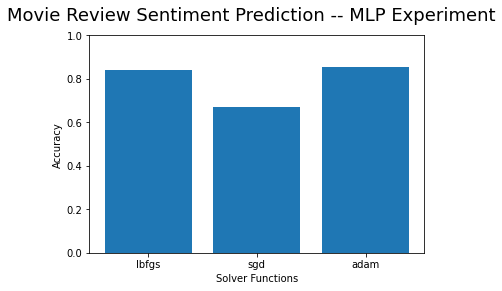

--------------------------------------------------------------
            P positive  P negative
T positive        4306         708
T negative         764        4222


In [ ]:
#MLP graph
plt.suptitle('Movie Review Sentiment Prediction -- MLP Experiment',fontsize=18)
plt.xlabel('Solver Functions')
plt.ylabel('Accuracy')
plt.bar(x=solver, height=mlp_accuracies)
plt.ylim([0,1])
plt.show()

print("--------------------------------------------------------------")

#MLP confusion matrix
conf_mat_mlp = metrics.confusion_matrix(test_sln, mlp_best_predictions, labels=vals)
print(pd.DataFrame(conf_mat_mlp, index = "T " + vals, columns = "P " + vals))

### Principal Component Analysis
__Using the model that performed the best, I will run a principal component analysis in an attempt to further improve its accuracy by reducing the dimensionality of the dataset.__

__Best Performace:__ MLP model with "Adam" solving function -- 85.28% accuracy

__Parameters tuned:__ number of hidden layers <br>
__Other adjustments:__ max iterations limited to 100, fixed random state, 'adam' solver, use inverse scaling learning rate to gradually decrease learning rate over time

In [ ]:
#import package for PCA
from sklearn.decomposition import PCA

#load in PCA that explains 95% of the variance
#As supported by an article written by Bartosz Mikulski
#https://www.mikulskibartosz.name/pca-how-to-choose-the-number-of-components/
extractor = PCA(n_components=.95, whiten=True)
extractor.fit(train_data_vectors, test_data_vectors)
train_transformed = extractor.transform(train_data_vectors)
test_transformed = extractor.transform(test_data_vectors)

In [ ]:
layers = [10,20,30,40,50,60,70,80,90,100]
mlp2_accuracies = []
mlp2_max_accuracy = 0
mlp2_best_layer = 0
mlp2_best_predictions = []
current_mlp2_accuracy = 0

#load in scikit-learn MLP again
for l in layers:
  mlp2 = MLPClassifier(hidden_layer_sizes = (l,), max_iter=100, random_state=21, solver="adam", learning_rate="invscaling")
  mlp2.fit(train_transformed,train_sln)
  predictions_mlp2 = mlp2.predict(test_transformed)
  current_mlp2_accuracy = metrics.accuracy_score(test_sln, predictions_mlp2)
  if current_mlp2_accuracy > mlp2_max_accuracy:
    mlp2_best_layer = l
    mlp2_max_accuracy = current_mlp2_accuracy
    mlp2_best_predictions = predictions_mlp2
  mlp2_accuracies.append(current_mlp2_accuracy)

#Conclusion
print("Best Number of Hidden Layers: ", mlp2_best_layer)
print("Best New MLP accuracy: ", mlp2_max_accuracy)

Best Number of Hidden Layers:  100
Best New MLP accuracy:  0.8441


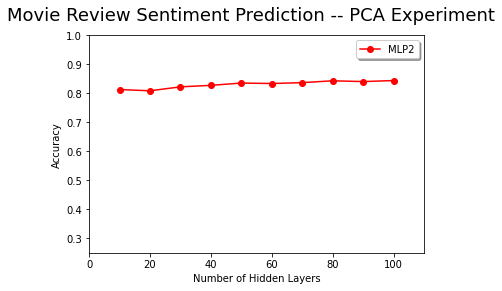

--------------------------------------------------------------
            P positive  P negative
T positive        4259         755
T negative         804        4182


In [ ]:
#MLP 2 graph
plt.suptitle('Movie Review Sentiment Prediction -- PCA Experiment',fontsize=18)
plt.xlabel('Number of Hidden Layers')
plt.ylabel('Accuracy')
plt.plot(layers, mlp2_accuracies, 'ro-', label='MLP2')
plt.legend(loc='best', shadow=True)
plt.axis([0,110,.25,1.0])
plt.show()

print("--------------------------------------------------------------")

#MLP 2 confusion matrix
conf_mat_mlp2 = metrics.confusion_matrix(test_sln, mlp2_best_predictions, labels=vals)
print(pd.DataFrame(conf_mat_mlp2, index = "T " + vals, columns = "P " + vals))

##Analysis

### <u>Bumps in the Road</u>

<p>The largest hurdle that I had to face in this experiment was constraining the data frame to a reasonable size. The first time I ran my Support Vector Classifier (SVC) algorithm, without making any prior adjustments, it took over 20 minutes to compute. I immediately knew I needed to make some changes. To correct this problem, I implemented a GPU to my program and limited the number of vectorized words to 1000. Once these alterations were made, I had no trouble getting the machine learning models to compile in a reasonable amount of time.</p>
<p>Another hurdle I faced in this project was determining how I would utilize each model's parameters. Considering each of these models have over a dozen parameters to choose from, it was difficult to decide on which ones to tune and which ones to hold constant. This ultimately required some trial and error, as well as some gradual building of parameters over time. I made my final decisions using my own curiosity, examples from in class activities, and suggestions from published data scientists.</p>

### <u>Results</u>

<p> The model that performed the best in this experiment was the multilayer perceptron (MLP) using the "adam" activation function and no pricipal component analysis (PCA). By achieving an accuracy of 85.28%, it edged out the second-best model (the same MLP after PCA) by 0.87%. As a whole, perceptron-based models performed very well in this experiment; all achieving a peak accuracy over 80%. The SVC, on the other hand, struggled and never exclipsed 53.47% accuracy during its analysis.</p>
<p>Looking closer at each of the confusion matrices, there were some interesting similarities that emerged. In every model, the number of positive sentiment predictions outnumbered the number of negative predictions. This was most apparent in the SVC model, where it predicted a positive review 81.33% of the time (8133/10000). To this point, the number of false positives (predicting positive when the sentiment was actually negative) outnumbered the number of false negatives (predicting negative when the sentiment was actually positive) in each of the most accurate models.</p>

In [3]:
#MLP graph
plt.suptitle('Movie Review Sentiment Prediction -- MLP Experiment',fontsize=18)
plt.xlabel('Solver Functions')
plt.ylabel('Accuracy')
plt.bar(x=solver, height=mlp_accuracies)
plt.ylim([0,1])
plt.show()

print("---------------------------------------------------------------")

#SVC confusion matrix
vals = data['sentiment'].unique() ## possible classification values
conf_mat_svc = metrics.confusion_matrix(test_sln, svc_best_predictions, labels=vals)
print(pd.DataFrame(conf_mat_svc, index = "T " + vals, columns = "P " + vals))

NameError: ignored

###<u>Discussion/Conclusion</u>
<p>Given the results of this experiment, I am confident some of these models would also perform well in the application of different sentiment predictions. Given some more training, it is very likely the MLP model with the "adam" activation function can achieve an accuracy greater than 90%. This could involve tuning other parameters, such as the learning rate, the use of a warm start to reuse previous outputs, or applying an epsilon value for improved stability. However, improvements to the single layer perceptron or other MLP with the "lbfgs" activation function could also be valuable, as these models also achieved initial accuracies over 80%. As a whole, MLP's are ideal for this kind of experiment where the weight of certain words plays a large part in the final sentiment. Therefore, as the number of epochs increases, these weights can be continually refined through back propogation to make the best model possible.</p>
<p>Although the construction of perceptrons allows for increased performance, one that struggled was a MLP with the stochastic gradient descent (SGD) acitvation function. While its final accuracy was still respectable (67.04%), it is clear it could have performed much better. However, the primary reason for this is not as much an issue with the model itself, but rather with the data set. This data set is very large (50,000 training examples), making it very easy for this activation function to overfit. This issue does not pose a problem for the other acitvation functions, and is proved by their better performance. While the SGD function struggled in this experiment, it could be valuable in building models for much smaller sets of data.</p>
<p>As for the first model trained, the SVC, it showed the most trouble of any model in this experiment. Despite increasing the degree for the polynomial in the kernel function, it was never able to improve its accuracy over time. This could be a result of several factors, most notably being that I forced this model to use a polynomial kernel. If more training were to be applied, this would be the first parameter that I would change. Another factor that could have hindered this model's performance is the size of this data set. Like the SGD activation function, SVC's are known to struggle with larger amounts of data, and it appears this theory proved to be crucial once again.</p>
<p>Looking closer at where each of these models made mistakes, it is clear these models struggled to predict negative reviews. In each of the four models tested, the number of false negatives always outweighed the number of false positives. Given that the average sentiment of the dataset matches its expected value, there is no bias within the data. This means there must be some bias that exists within the current models, and would need to be  addressed in later tuning. If these models were to limit their positive bias, their overall accuracy would increase significantly and become even more reliable for a number of sentiment prediction applications.</p>